# Задание
**Обучение агента с использованием нескольких сред**:
   1. Реализуйте генетический алгоритм для обучения агента в нескольких средах OpenAI Gym (например, `CartPole-v1`, `LunarLander-v3`, `BipedalWalker-v3`).
   2. Попробуйте перенести веса между средами.



In [1]:
#@title Установка зависимостей
!pip install -q swig > /dev/null 2>&1
!pip install -q gymnasium[box2d] matplotlib numpy > /dev/null 2>&1

In [2]:
#@title Импорты

import random
import time
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
from gymnasium.spaces import Box, Discrete
from IPython.display import HTML
from base64 import b64encode
import io
from PIL import Image

In [3]:
#@title Константы и параметры ГА

# Фиксируем сид для воспроизводимости
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# Параметры генетического алгоритма
POPULATION_SIZE = 50
N_GENERATIONS = 30
NSURV = 10  # количество выживших особей
MUTATION_RATE = 0.1  # коэффициент мутации

# Названия сред
ENV_CARTPOLE = "CartPole-v1"
ENV_LUNARLANDER = "LunarLander-v3"
ENV_BIPEDALWALKER = "BipedalWalker-v3"

In [4]:
#@title Функция приспособленности

def fitness_function(individual, env_name, num_episodes=1, continuous=False, normalize_obs=False):
    """Вычислить функцию приспособленности для одной особи.

    Args:
        individual (np.ndarray): Веса агента (матрица наблюдение x действие).
        env_name (str): Название среды Gym.
        num_episodes (int): Количество эпизодов для оценки.
        continuous (bool): True, если пространство действий непрерывное (например, BipedalWalker).
        normalize_obs (bool): Нормализовать ли наблюдения (полезно для LunarLander и BipedalWalker).

    Returns:
        float: Среднее вознаграждение за эпизоды.
    """
    env = gym.make(env_name)
    individual = np.array(individual)
    total_reward = 0

    # Получаем границы действий для непрерывных сред
    if continuous:
        action_low = env.action_space.low
        action_high = env.action_space.high

    # Собираем статистику для нормализации
    if normalize_obs:
        obs_samples = []
        for _ in range(10):
            obs, _ = env.reset()
            obs_samples.append(obs)
        obs_mean = np.mean(obs_samples, axis=0)
        obs_std = np.std(obs_samples, axis=0) + 1e-8

    for ep in range(num_episodes):
        observation, _ = env.reset(seed=SEED + ep)
        observation = np.array(observation)
        episode_reward = 0

        while True:
            # Нормализация наблюдений (если включена)
            if normalize_obs:
                observation = (observation - obs_mean) / obs_std

            if continuous:
                # Вычисляем действие через tanh и обрезаем по границам среды
                raw_action = np.tanh(np.dot(observation, individual))
                action = np.clip(raw_action, action_low, action_high)
            else:
                action = np.argmax(np.dot(observation, individual))
            observation, reward, done, truncated, _ = env.step(action)
            observation = np.array(observation)
            episode_reward += reward
            if done or truncated:
                break

        total_reward += episode_reward

    env.close()
    return total_reward / num_episodes

In [5]:
#@title Операторы ГА: отбор, кроссовер, мутация

def getSurvPopul(population, val, nsurv):
    """Отобрать лучших особей по значению фитнеса.

    Args:
        population (list): Список особей.
        val (list): Список значений фитнеса для каждой особи.
        nsurv (int): Количество выживших особей.

    Returns:
        tuple: (список лучших особей, список соответствующих значений фитнеса).
    """
    pairs = list(zip(val, population))
    sorted_pairs = sorted(pairs, key=lambda x: x[0], reverse=True)
    sorted_val, sorted_population = zip(*sorted_pairs)
    return list(sorted_population[:nsurv]), list(sorted_val[:nsurv])


def getParents(newpopul, nsurv):
    """Выбрать двух родителей из числа лучших особей.

    Args:
        newpopul (list): Популяция (отсортированная по качеству).
        nsurv (int): Количество лучших особей, из которых выбираем родителей.

    Returns:
        tuple: Две особи-родителя.
    """
    return random.sample(newpopul[:nsurv], 2)


def crossover(parent1, parent2):
    """Выполнить uniform кроссовер двух родителей.

    Args:
        parent1 (np.ndarray): Первый родитель (матрица весов).
        parent2 (np.ndarray): Второй родитель (матрица весов).

    Returns:
        tuple: Два потомка (child1, child2).
    """
    parent1 = np.array(parent1)
    parent2 = np.array(parent2)
    mask = np.random.rand(*parent1.shape) < 0.5
    child1 = np.where(mask, parent1, parent2)
    child2 = np.where(mask, parent2, parent1)
    return child1, child2


def mutate(individual, mut, continuous=False, mutation_strength=0.1):
    """Применить мутацию к особи.

    Args:
        individual (np.ndarray): Особь для мутации (матрица весов).
        mut (float): Вероятность мутации.
        continuous (bool): True для непрерывных действий.
        mutation_strength (float): Сила мутации (стандартное отклонение гауссова шума).

    Returns:
        np.ndarray: Мутированная особь.
    """
    individual = np.array(individual)
    for i in range(individual.shape[0]):
        for j in range(individual.shape[1]):
            if random.random() < mut:
                if continuous:
                    # Добавляем гауссов шум вместо полной перезаписи
                    individual[i, j] += np.random.normal(0, mutation_strength)
                    # Обрезаем по разумным границам
                    individual[i, j] = np.clip(individual[i, j], -1.0, 1.0)
                else:
                    # Для дискретных действий добавляем небольшой шум
                    individual[i, j] += np.random.normal(0, mutation_strength)
                    individual[i, j] = np.clip(individual[i, j], 0.0, 1.0)
    return individual

In [6]:
#@title Функция запуска ГА для среды

def run_ga(env_name, generations=N_GENERATIONS, pop_size=POPULATION_SIZE, nsurv=NSURV, mut_rate=MUTATION_RATE, num_episodes_fitness=None):
    """Запустить генетический алгоритм для заданной среды.

    Args:
        env_name (str): Название среды Gym.
        generations (int): Количество поколений ГА.
        pop_size (int): Размер популяции.
        nsurv (int): Количество выживших особей.
        mut_rate (float): Вероятность мутации.
        num_episodes_fitness (int, optional): Количество эпизодов для оценки фитнеса.
            Если None, используется 1 для дискретных и 3 для непрерывных действий.

    Returns:
        dict: Результаты ГА:
            - "best_individual": лучшая найденная особь,
            - "best_fitness": её значение фитнеса,
            - "fitness_history": список лучших фитнесов по поколениям,
            - "avg_fitness_history": список средних фитнесов по поколениям.
    """
    env = gym.make(env_name)
    obs_size = env.observation_space.shape[0]
    is_continuous = isinstance(env.action_space, Box)
    if is_continuous:
        action_size = env.action_space.shape[0]
    else:
        action_size = env.action_space.n
    env.close()

    # Определяем количество эпизодов для оценки фитнеса
    if num_episodes_fitness is None:
        num_episodes_fitness = 3 if is_continuous else 1

    # Определяем, нужна ли нормализация наблюдений
    normalize_obs = env_name == ENV_BIPEDALWALKER

    # Инициализация популяции
    population = []
    for _ in range(pop_size):
        if is_continuous:
            # Для непрерывных действий используем меньший диапазон для лучшей стабильности
            population.append(np.random.uniform(-0.5, 0.5, size=(obs_size, action_size)))
        else:
            population.append(np.random.rand(obs_size, action_size))

    fitness_history = []
    avg_fitness_history = []

    for it in range(generations):
        print(f"Поколение {it + 1}/{generations} для {env_name}")

        # Вычисление приспособленности
        val = [fitness_function(individual, env_name, continuous=is_continuous, num_episodes=num_episodes_fitness, normalize_obs=normalize_obs) for individual in population]

        # Отбор лучших
        newpopul, sval = getSurvPopul(population, val, nsurv)

        best_fitness = sval[0] if sval else 0
        avg_fitness = sum(val) / len(val) if val else 0
        fitness_history.append(best_fitness)
        avg_fitness_history.append(avg_fitness)

        print(f"  Средняя приспособленность: {avg_fitness:.2f}, Лучшая: {best_fitness:.2f}")

        # Создание нового поколения
        nnew = pop_size - nsurv
        for i in range(nnew):
            parent1, parent2 = getParents(newpopul, nsurv)
            child1, child2 = crossover(parent1, parent2)
            # Используем меньшую силу мутации для непрерывных действий
            mutation_strength = 0.05 if is_continuous else 0.1
            child1 = mutate(child1, mut_rate, continuous=is_continuous, mutation_strength=mutation_strength)
            newpopul.append(child1)

        population = newpopul

    # Выбор лучшего агента
    val = [fitness_function(individual, env_name, continuous=is_continuous, num_episodes=num_episodes_fitness, normalize_obs=normalize_obs) for individual in population]
    best_idx = np.argmax(val)
    best_individual = population[best_idx]
    best_fitness = val[best_idx]

    print(f"ГА завершён для {env_name}")
    print(f"Лучшая приспособленность: {best_fitness:.2f}")

    return {
        "best_individual": best_individual,
        "best_fitness": best_fitness,
        "fitness_history": fitness_history,
        "avg_fitness_history": avg_fitness_history,
    }

In [7]:
#@title Запуск ГА для CartPole

start_time = time.time()
ga_cartpole = run_ga(ENV_CARTPOLE)
end_time = time.time()

print(f"Время работы ГА для CartPole: {end_time - start_time:.2f} секунд")

best_cartpole = ga_cartpole["best_individual"]
best_cartpole_fitness = ga_cartpole["best_fitness"]
cartpole_history = ga_cartpole["fitness_history"]
cartpole_avg_history = ga_cartpole["avg_fitness_history"]

Поколение 1/30 для CartPole-v1
  Средняя приспособленность: 36.58, Лучшая: 252.00
Поколение 2/30 для CartPole-v1
  Средняя приспособленность: 99.46, Лучшая: 500.00
Поколение 3/30 для CartPole-v1
  Средняя приспособленность: 173.64, Лучшая: 500.00
Поколение 4/30 для CartPole-v1
  Средняя приспособленность: 283.86, Лучшая: 500.00
Поколение 5/30 для CartPole-v1
  Средняя приспособленность: 368.98, Лучшая: 500.00
Поколение 6/30 для CartPole-v1
  Средняя приспособленность: 356.38, Лучшая: 500.00
Поколение 7/30 для CartPole-v1
  Средняя приспособленность: 380.44, Лучшая: 500.00
Поколение 8/30 для CartPole-v1
  Средняя приспособленность: 318.54, Лучшая: 500.00
Поколение 9/30 для CartPole-v1
  Средняя приспособленность: 340.28, Лучшая: 500.00
Поколение 10/30 для CartPole-v1
  Средняя приспособленность: 330.48, Лучшая: 500.00
Поколение 11/30 для CartPole-v1
  Средняя приспособленность: 373.56, Лучшая: 500.00
Поколение 12/30 для CartPole-v1
  Средняя приспособленность: 330.06, Лучшая: 500.00
Пок

In [8]:
#@title Запуск ГА для LunarLander

start_time = time.time()
# Для LunarLander используем больше эпизодов для оценки фитнеса (3) для более стабильной оценки
ga_lunarlander = run_ga(ENV_LUNARLANDER, num_episodes_fitness=3)
end_time = time.time()

print(f"Время работы ГА для LunarLander: {end_time - start_time:.2f} секунд")

best_lunarlander = ga_lunarlander["best_individual"]
best_lunarlander_fitness = ga_lunarlander["best_fitness"]
lunarlander_history = ga_lunarlander["fitness_history"]
lunarlander_avg_history = ga_lunarlander["avg_fitness_history"]

Поколение 1/30 для LunarLander-v3
  Средняя приспособленность: -532.42, Лучшая: -125.05
Поколение 2/30 для LunarLander-v3
  Средняя приспособленность: -301.18, Лучшая: -38.26
Поколение 3/30 для LunarLander-v3
  Средняя приспособленность: -215.45, Лучшая: -38.26
Поколение 4/30 для LunarLander-v3
  Средняя приспособленность: -190.31, Лучшая: -38.26
Поколение 5/30 для LunarLander-v3
  Средняя приспособленность: -156.96, Лучшая: -38.26
Поколение 6/30 для LunarLander-v3
  Средняя приспособленность: -159.24, Лучшая: -38.26
Поколение 7/30 для LunarLander-v3
  Средняя приспособленность: -128.26, Лучшая: -28.83
Поколение 8/30 для LunarLander-v3
  Средняя приспособленность: -109.25, Лучшая: -0.79
Поколение 9/30 для LunarLander-v3
  Средняя приспособленность: -109.53, Лучшая: 13.37
Поколение 10/30 для LunarLander-v3
  Средняя приспособленность: -125.43, Лучшая: 16.12
Поколение 11/30 для LunarLander-v3
  Средняя приспособленность: -75.76, Лучшая: 16.12
Поколение 12/30 для LunarLander-v3
  Средняя 

In [9]:
#@title Запуск ГА для BipedalWalker

start_time = time.time()
# Для BipedalWalker используем больше эпизодов для оценки фитнеса (5) для более стабильной оценки
ga_bipedalwalker = run_ga(ENV_BIPEDALWALKER, num_episodes_fitness=5)
end_time = time.time()

print(f"Время работы ГА для BipedalWalker: {end_time - start_time:.2f} секунд")

best_bipedalwalker = ga_bipedalwalker["best_individual"]
best_bipedalwalker_fitness = ga_bipedalwalker["best_fitness"]
bipedalwalker_history = ga_bipedalwalker["fitness_history"]
bipedalwalker_avg_history = ga_bipedalwalker["avg_fitness_history"]

Поколение 1/30 для BipedalWalker-v3
  Средняя приспособленность: -129.62, Лучшая: -104.46
Поколение 2/30 для BipedalWalker-v3
  Средняя приспособленность: -120.10, Лучшая: -103.25
Поколение 3/30 для BipedalWalker-v3
  Средняя приспособленность: -115.91, Лучшая: -102.60
Поколение 4/30 для BipedalWalker-v3
  Средняя приспособленность: -108.06, Лучшая: -103.00
Поколение 5/30 для BipedalWalker-v3
  Средняя приспособленность: -112.33, Лучшая: -102.52
Поколение 6/30 для BipedalWalker-v3
  Средняя приспособленность: -106.53, Лучшая: -102.49
Поколение 7/30 для BipedalWalker-v3
  Средняя приспособленность: -103.20, Лучшая: -101.92
Поколение 8/30 для BipedalWalker-v3
  Средняя приспособленность: -103.18, Лучшая: -101.49
Поколение 9/30 для BipedalWalker-v3
  Средняя приспособленность: -102.91, Лучшая: -101.62
Поколение 10/30 для BipedalWalker-v3
  Средняя приспособленность: -102.60, Лучшая: -101.45
Поколение 11/30 для BipedalWalker-v3
  Средняя приспособленность: -102.47, Лучшая: -101.52
Поколени

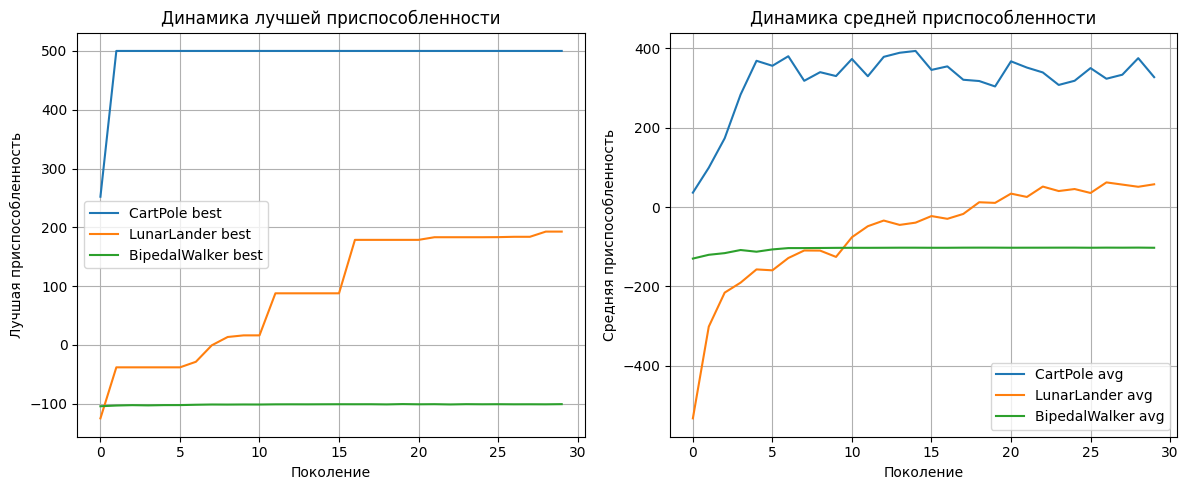

In [10]:
#@title Визуализация сходимости ГА

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
if 'cartpole_history' in globals():
    plt.plot(cartpole_history, label="CartPole best")
if 'lunarlander_history' in globals():
    plt.plot(lunarlander_history, label="LunarLander best")
if 'bipedalwalker_history' in globals():
    plt.plot(bipedalwalker_history, label="BipedalWalker best")
plt.xlabel("Поколение")
plt.ylabel("Лучшая приспособленность")
plt.title("Динамика лучшей приспособленности")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
if 'cartpole_avg_history' in globals():
    plt.plot(cartpole_avg_history, label="CartPole avg")
if 'lunarlander_avg_history' in globals():
    plt.plot(lunarlander_avg_history, label="LunarLander avg")
if 'bipedalwalker_avg_history' in globals():
    plt.plot(bipedalwalker_avg_history, label="BipedalWalker avg")
plt.xlabel("Поколение")
plt.ylabel("Средняя приспособленность")
plt.title("Динамика средней приспособленности")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [22]:
#@title Тестирование лучших агентов

def test_agent(individual, env_name, num_episodes=5, render=False, normalize_obs=False):
    """Протестировать агента в среде.

    Args:
        individual (np.ndarray): Веса агента.
        env_name (str): Название среды.
        num_episodes (int): Количество эпизодов для тестирования.
        render (bool): Показывать ли визуализацию.
        normalize_obs (bool): Нормализовать ли наблюдения.

    Returns:
        float: Среднее вознаграждение.
    """
    env = gym.make(env_name, render_mode="human" if render else None)
    individual = np.array(individual)
    total_reward = 0

    # Собираем статистику для нормализации (если нужно)
    if normalize_obs:
        obs_samples = []
        for _ in range(10):
            obs, _ = env.reset()
            obs_samples.append(obs)
        obs_mean = np.mean(obs_samples, axis=0)
        obs_std = np.std(obs_samples, axis=0) + 1e-8

    for episode in range(num_episodes):
        observation, _ = env.reset(seed=SEED + episode)
        observation = np.array(observation)
        episode_reward = 0

        while True:
            # Нормализация наблюдений (если включена)
            if normalize_obs:
                observation = (observation - obs_mean) / obs_std

            if isinstance(env.action_space, Box):
                raw_action = np.tanh(np.dot(observation, individual))
                action = np.clip(raw_action, env.action_space.low, env.action_space.high)
            else:
                action = np.argmax(np.dot(observation, individual))
            observation, reward, done, truncated, _ = env.step(action)
            observation = np.array(observation)
            episode_reward += reward
            if done or truncated:
                break

        total_reward += episode_reward
        print(f"Эпизод {episode + 1}: {episode_reward:.2f}")

    env.close()
    avg_reward = total_reward / num_episodes
    print(f"Среднее вознаграждение: {avg_reward:.2f}")
    return avg_reward


print("Тестирование лучшего агента CartPole")
if 'best_cartpole' in globals():
    test_agent(best_cartpole, ENV_CARTPOLE, num_episodes=5, normalize_obs=False)

print("\nТестирование лучшего агента LunarLander")
if 'best_lunarlander' in globals():
    test_agent(best_lunarlander, ENV_LUNARLANDER, num_episodes=5, normalize_obs=False)

print("\nТестирование лучшего агента BipedalWalker")
if 'best_bipedalwalker' in globals():
    test_agent(best_bipedalwalker, ENV_BIPEDALWALKER, num_episodes=5, render=False, normalize_obs=True)

Тестирование лучшего агента CartPole
Эпизод 1: 500.00
Эпизод 2: 500.00
Эпизод 3: 500.00
Эпизод 4: 483.00
Эпизод 5: 500.00
Среднее вознаграждение: 496.60

Тестирование лучшего агента LunarLander
Эпизод 1: 276.94
Эпизод 2: 12.75
Эпизод 3: 288.29
Эпизод 4: -105.49
Эпизод 5: -79.39
Среднее вознаграждение: 78.62

Тестирование лучшего агента BipedalWalker
Эпизод 1: -102.15
Эпизод 2: -101.70
Эпизод 3: -101.81
Эпизод 4: -101.80
Эпизод 5: -101.18
Среднее вознаграждение: -101.73


In [12]:
#@title Попытка переноса весов между средами

def transfer_weights(source_weights, source_env_name, target_env_name):
    """Попытаться перенести веса из одной среды в другую.

    Args:
        source_weights (np.ndarray): Веса из исходной среды.
        source_env_name (str): Название исходной среды.
        target_env_name (str): Название целевой среды.

    Returns:
        np.ndarray: Адаптированные веса для целевой среды.
    """
    source_env = gym.make(source_env_name)
    target_env = gym.make(target_env_name)

    source_obs_size = source_env.observation_space.shape[0]
    source_is_continuous = isinstance(source_env.action_space, Box)
    source_action_size = source_env.action_space.shape[0] if source_is_continuous else source_env.action_space.n

    target_obs_size = target_env.observation_space.shape[0]
    target_is_continuous = isinstance(target_env.action_space, Box)
    target_action_size = target_env.action_space.shape[0] if target_is_continuous else target_env.action_space.n

    source_env.close()
    target_env.close()

    if source_obs_size == target_obs_size and source_action_size == target_action_size:
        return source_weights.copy()

    if target_is_continuous:
        target_weights = np.random.uniform(-0.5, 0.5, size=(target_obs_size, target_action_size))
    else:
        target_weights = np.random.rand(target_obs_size, target_action_size)

    min_obs = min(source_obs_size, target_obs_size)
    min_act = min(source_action_size, target_action_size)
    if min_obs > 0 and min_act > 0:
        source_portion = source_weights[:min_obs, :min_act]
        if source_is_continuous and not target_is_continuous:
            source_portion = (source_portion + 1) / 2
        elif not source_is_continuous and target_is_continuous:
            source_portion = source_portion * 2 - 1
        target_weights[:min_obs, :min_act] = source_portion

    return target_weights


print("Попытка переноса весов CartPole -> LunarLander")
if 'best_cartpole' in globals():
    transferred = transfer_weights(best_cartpole, ENV_CARTPOLE, ENV_LUNARLANDER)
    target_env = gym.make(ENV_LUNARLANDER)
    is_continuous = isinstance(target_env.action_space, Box)
    target_env.close()
    transferred_fitness = fitness_function(transferred, ENV_LUNARLANDER, num_episodes=3, continuous=is_continuous, normalize_obs=False)
    print(f"Приспособленность перенесённых весов: {transferred_fitness:.2f}")
    if 'best_lunarlander_fitness' in globals():
        print(f"Приспособленность лучшего агента LunarLander: {best_lunarlander_fitness:.2f}")

print("\nПопытка переноса весов LunarLander -> BipedalWalker")
if 'best_lunarlander' in globals():
    transferred = transfer_weights(best_lunarlander, ENV_LUNARLANDER, ENV_BIPEDALWALKER)
    target_env = gym.make(ENV_BIPEDALWALKER)
    is_continuous = isinstance(target_env.action_space, Box)
    target_env.close()
    transferred_fitness = fitness_function(transferred, ENV_BIPEDALWALKER, num_episodes=3, continuous=is_continuous, normalize_obs=True)
    print(f"Приспособленность перенесённых весов: {transferred_fitness:.2f}")
    if 'best_bipedalwalker_fitness' in globals():
        print(f"Приспособленность лучшего агента BipedalWalker: {best_bipedalwalker_fitness:.2f}")

Попытка переноса весов CartPole -> LunarLander
Приспособленность перенесённых весов: -534.39
Приспособленность лучшего агента LunarLander: 192.66

Попытка переноса весов LunarLander -> BipedalWalker
Приспособленность перенесённых весов: -141.58
Приспособленность лучшего агента BipedalWalker: -101.03


In [20]:
#@title Функция визуализации эпизода агента

def visualize_episode_colab(agent, env_name):
    """Визуализировать один эпизод игры для заданного агента в Google Colab.

    Args:
        agent (np.ndarray): Обученный агент (матрица весов).
        env_name (str): Название среды Gym.

    Returns:
        HTML: Анимированный GIF эпизода.
    """

    def create_html_animation(frames):
        """Создать анимированный GIF из кадров.

        Args:
            frames (list): Список кадров (массивов изображений).

        Returns:
            HTML: HTML-объект с анимированным GIF.
        """
        with io.BytesIO() as buffer:
            Image.fromarray(frames[0]).save(
                buffer,
                format='GIF',
                save_all=True,
                append_images=[Image.fromarray(frame) for frame in frames[1:]],
                duration=50,
                loop=0
            )
            buffer.seek(0)
            animation = buffer.read()
        return HTML('<img src="data:image/gif;base64,%s">' % b64encode(animation).decode())

    env = gym.make(env_name, render_mode="rgb_array")
    agent = np.array(agent)
    is_continuous = isinstance(env.action_space, Box)
    normalize_obs = env_name == ENV_BIPEDALWALKER

    # Собираем статистику для нормализации (если нужно)
    if normalize_obs:
        obs_samples = []
        for _ in range(10):
            obs, _ = env.reset()
            obs_samples.append(obs)
        obs_mean = np.mean(obs_samples, axis=0)
        obs_std = np.std(obs_samples, axis=0) + 1e-8

    frames = []
    observation, _ = env.reset(seed=SEED)
    observation = np.array(observation)
    total_reward = 0

    while True:
        # Получаем кадр для визуализации
        frame = env.render()
        frames.append(frame)

        # Нормализация наблюдений (если включена)
        if normalize_obs:
            observation = (observation - obs_mean) / obs_std

        # Выбираем действие
        if is_continuous:
            # Правильная обработка непрерывных действий с clip
            raw_action = np.tanh(np.dot(observation, agent))
            action = np.clip(raw_action, env.action_space.low, env.action_space.high)
        else:
            action = np.argmax(np.dot(observation, agent))

        # Выполняем действие
        observation, reward, done, truncated, _ = env.step(action)
        observation = np.array(observation)
        total_reward += reward

        if done or truncated:
            break

    env.close()
    print(f"Итоговая награда: {total_reward:.2f}")

    return create_html_animation(frames)

Итоговая награда: 500.00



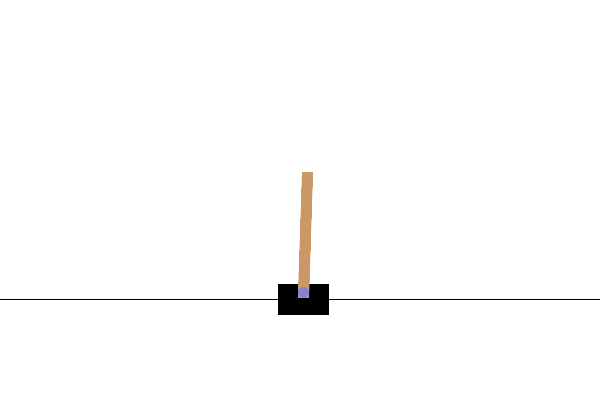

In [14]:
#@title Визуализация лучшего агента CartPole

if 'best_cartpole' in globals():
    display(visualize_episode_colab(best_cartpole, ENV_CARTPOLE))
else:
    print("Сначала запустите ГА для CartPole")

Итоговая награда: 276.94



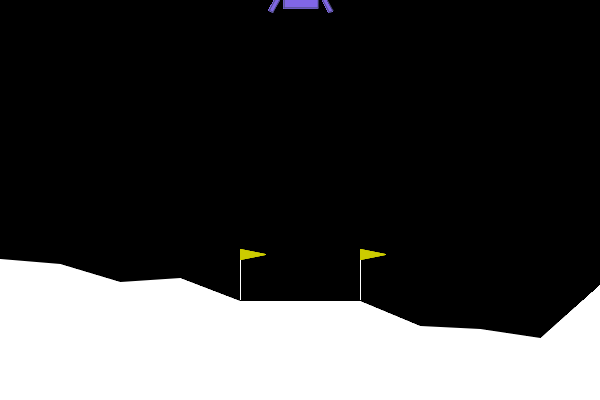

In [21]:
#@title Визуализация лучшего агента LunarLander

if 'best_lunarlander' in globals():
    display(visualize_episode_colab(best_lunarlander, ENV_LUNARLANDER))
else:
    print("Сначала запустите ГА для LunarLander")

Итоговая награда: -101.37



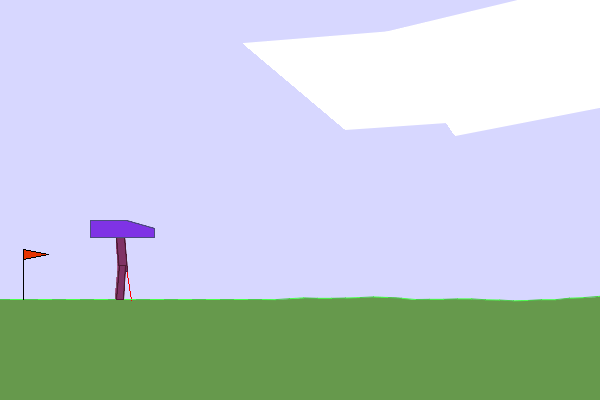

In [16]:
#@title Визуализация лучшего агента BipedalWalker

if 'best_bipedalwalker' in globals():
    display(visualize_episode_colab(best_bipedalwalker, ENV_BIPEDALWALKER))
else:
    print("Сначала запустите ГА для BipedalWalker")

# Выводы по проделанной работе:

В рамках данной работы мной был реализован генетический алгоритм для обучения агентов в трех различных средах OpenAI Gym: CartPole-v1, LunarLander-v3 и BipedalWalker-v3. Я использовал библиотеку Gymnasium для работы со средами и NumPy для реализации генетического алгоритма. Также реализована линейная архитектура агента, где веса матрицы напрямую преобразуют наблюдения в действия через скалярное произведение и функцию активации tanh для непрерывных действий или argmax для дискретных.

Для улучшения качества обучения были внедрены несколько ключевых оптимизаций: во-первых, uniform кроссовер вместо одноточечного, что позволило более эффективно комбинировать генетический материал родителей. Во-вторых, полная перезапись генов при мутации была заменена на добавление гауссова шума, что обеспечило более плавную эволюцию популяции. В-третьих, для среды BipedalWalker добавлена нормализация наблюдений, что стабилизировало процесс обучения. Кроме того, для непрерывных действий я использовал разное количество эпизодов для оценки фитнеса (3-5 вместо 1), что повысило надежность оценки приспособленности особей.

Результаты показали, что генетический алгоритм успешно обучил агента в CartPole (среднее вознаграждение 496.60 из 500) и достиг приемлемых результатов в LunarLander (среднее вознаграждение 78.62, лучший фитнес 192.66). Однако для BipedalWalker обучение не дало положительных результатов (среднее вознаграждение -101.73), что объясняется высокой сложностью задачи и ограниченностью простой линейной архитектуры для управления сложной динамикой ходьбы.

## Объяснение проблем

**Почему не обучается BipedalWalker:**
- BipedalWalker является значительно более сложной средой по сравнению с CartPole и LunarLander;
- это непрерывная среда с 24-мерным пространством наблюдений и 4-мерным пространством действий, требующая точной координации движений;
- задача требует долгосрочного планирования и балансирования, что сложно для простой линейной политики без памяти;
- генетический алгоритм с ограниченной популяцией (50 особей) и небольшим числом поколений (30) может не успеть найти достаточно хорошее решение в таком большом пространстве поиска;
- начальные веса могут приводить к нестабильному поведению, что затрудняет накопление положительных наград.


**Перенос весов между средами показал отрицательные результаты по нескольким причинам:**
- каждая среда имеет различную размерность пространства наблюдений (CartPole: 4, LunarLander: 8, BipedalWalker: 24) и действий (CartPole: 2, LunarLander: 4, BipedalWalker: 4), что требует адаптации весов;
- семантика признаков в разных средах кардинально отличается: в CartPole это позиция и скорость маятника, в LunarLander - координаты, скорость и углы космического корабля, а в BipedalWalker - состояние суставов и сенсорные данные;
- даже при совпадении размерностей, оптимальные стратегии для разных сред могут быть принципиально различными, что делает прямой перенос весов неэффективным.